# **Automatidata project**
**Regression Analysis: Simplify complex data relationships**

# Build a multiple linear regression model

<img src="images/Plan.png" width="100" height="100" align=left>


## PACE: **Plan**

Consider the questions in your PACE Strategy Document & ethical considerations of ML model.


### Task 1. Imports and loading

In [1]:
# Imports
# Packages for numerics + dataframes
import numpy as np
import pandas as pd

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions for calculating trip durations
import datetime

# Packages for OLS, MLR, confusion matrix
import statsmodels.api as sm 
import sklearn.metrics as metrics


In [ ]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
# Load dataset into dataframe 
df = pd.read_csv(DATA / "2017_Yellow_Taxi_Trip_Data.csv", index_col=0) 

## PACE: **Analyze**

Consider the purposes of EDA before constructing a multiple linear regression model:
- Explore & examine the data quality and ethics
  (eg. distribution of the features, such as range, mean, spread).
- To clean & manipulate data for effective modeling such as retifying missing values, incorrect entries, or inconsistent type / format. As generally, libraries like `statsmodels` & `scikit-learn` would not respond well to erroneous data.   


### Task 2a. Explore data with EDA

Analyze and discover data, looking for correlations, missing data, outliers, and duplicates.

In [4]:
# Create a copy (df) where changes will go
df_trips = df.copy()

# Start with `.shape` and `.info()`
df_trips.shape

(22699, 17)

In [5]:
df_trips.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22699 entries, 24870114 to 17208911
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               22699 non-null  int64  
 1   tpep_pickup_datetime   22699 non-null  object 
 2   tpep_dropoff_datetime  22699 non-null  object 
 3   passenger_count        22699 non-null  int64  
 4   trip_distance          22699 non-null  float64
 5   RatecodeID             22699 non-null  int64  
 6   store_and_fwd_flag     22699 non-null  object 
 7   PULocationID           22699 non-null  int64  
 8   DOLocationID           22699 non-null  int64  
 9   payment_type           22699 non-null  int64  
 10  fare_amount            22699 non-null  float64
 11  extra                  22699 non-null  float64
 12  mta_tax                22699 non-null  float64
 13  tip_amount             22699 non-null  float64
 14  tolls_amount           22699 non-null  float

In [6]:
# Check for missing data and duplicates using .isna() and .drop_duplicates()
df_trips.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [7]:
df_trips.index.duplicated().sum()

# Since there's no duplicate trip as shown by the unique trip identification number,
# `drop_duplicates()` is not needed. 

0

In [8]:
# Examine the descriptive statistics of data
df_trips.describe()


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
std,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000


**Note:** Some things stand out from this table of summary statistics. For instance, there are clearly some outliers in several variables, like `tip_amount` (\$200) and `total_amount` (\$1,200). Also, a number of the variables, such as `mta_tax`, seem to be almost constant throughout the data, which would imply that they would not be expected to be very predictive.

### Task 2b. Convert pickup & dropoff columns to datetime


In [9]:
# Check the format of the data
df_trips[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].head()


,tpep_pickup_datetime,tpep_dropoff_datetime
24870114,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM
35634249,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM
106203690,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM
38942136,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM
30841670,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM


In [10]:
# Convert datetime columns to datetime
df_trips.tpep_pickup_datetime = pd.to_datetime(df_trips['tpep_pickup_datetime'])
df_trips.tpep_dropoff_datetime = pd.to_datetime(df_trips['tpep_dropoff_datetime'])
df_trips[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]

,tpep_pickup_datetime,tpep_dropoff_datetime
24870114,2017-03-25 08:55:43,2017-03-25 09:09:47
35634249,2017-04-11 14:53:28,2017-04-11 15:19:58
106203690,2017-12-15 07:26:56,2017-12-15 07:34:08
38942136,2017-05-07 13:17:59,2017-05-07 13:48:14
30841670,2017-04-15 23:32:20,2017-04-15 23:49:03
...,...,...
14873857,2017-02-24 17:37:23,2017-02-24 17:40:39
66632549,2017-08-06 16:43:59,2017-08-06 17:24:47
74239933,2017-09-04 14:54:14,2017-09-04 14:58:22
60217333,2017-07-15 12:56:30,2017-07-15 13:08:26


### Task 2c. Create duration column

Create a new column called `duration` that represents the total number of minutes that each taxi ride took.

In [11]:
# Create `duration` column
timespans = df_trips.tpep_dropoff_datetime - df_trips.tpep_pickup_datetime
df_trips.insert(loc=3, column='duration', value=timespans.dt.total_seconds() / 60)
df_trips.duration.head(3)

24870114     14.066667
35634249     26.500000
106203690     7.200000
Name: duration, dtype: float64

### Outliers

Call `df.info()` to inspect the columns and decide which ones to check for outliers.

In [12]:
df_trips.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22699 entries, 24870114 to 17208911
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               22699 non-null  int64         
 1   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 3   duration               22699 non-null  float64       
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64    

**Keeping in mind that many of the features will not be used to fit the model, the important columns to check for outliers are likely to be:**
* `trip_distance`
* `fare_amount`
* `duration`



### Task 2d. Box plots

Plot a box plot for each feature: `trip_distance`, `fare_amount`, `duration`.

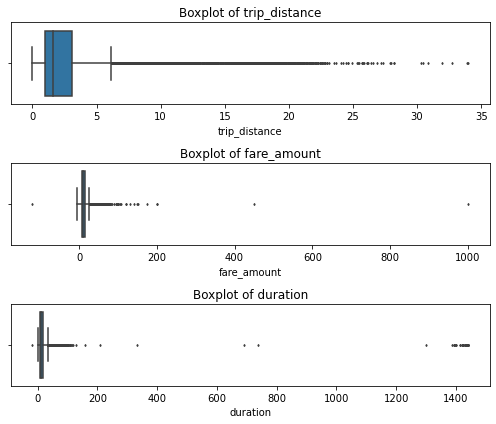

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7, 6))
for i, col in enumerate(['trip_distance', 'fare_amount', 'duration']):
    sns.boxplot(x=df_trips[col], fliersize=1.5, ax=ax[i])
    ax[i].set(title='Boxplot of ' + col)
fig.tight_layout()

**Questions:** 
1. Which variable(s) contains outliers? 

2. Are the values in the `trip_distance` column unbelievable?

3. What about the lower end? Do distances, fares, and durations of 0 (or negative values) make sense?

- From the viz, all of the variables contain outliers. 
- It's 30 miles from the southern tip of Staten Island to the northern end of Manhattan and that's in a straight line. With this knowledge and the distribution of the values in this column, it's reasonable to leave these values alone and not alter them.
- As identified in earlier EDA activity, the illogical 0 values presented in `trip_distance` were unattended trips charged based on waiting time rate & to the airports respectively. 
- For the negative fare amounts, there were only few records identified as unassured payments & dispute which may be removed accordingly. 
- Where, the 0 & negative values in duration are likely due to cause of dispute or unattended trips from `trip_distance` and `fare_amount`.   

### Task 2e. Imputations

#### `trip_distance` outliers

From the summary statistics, there are trip distances of 0. Are these reflective of erroneous data, or are they very short trips that get rounded down?

In [14]:
# Inspect the least 10 unique values to determine if the 0 values are rounded or precise values.
sorted(set(df_trips.trip_distance))[:10]

# As the trip_distance increases incrementally across the sorted distance record, it is very unlikely the records are rounded values. 

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

In [15]:
# Examine the count of rides where `trip_distance` = 0 
df_trips.loc[df_trips.trip_distance == 0, 'trip_distance'].count()

# With only small no. of records posing a zero-value problem, we can choose to drop the rows 
# or simply leave them as they are generally not a problem in model fitting for such a big data. 

148

#### `fare_amount` outliers

In [16]:
df_trips.loc[((df_trips.fare_amount <= 0) & (~df_trips.payment_type.isin([3, 4])))]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,duration,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
108016954,2,2017-12-20 16:06:53,2017-12-20 16:47:50,40.950000,1,7.06,1,N,263,169,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49670364,2,2017-06-12 12:08:55,2017-06-12 12:08:57,0.033333,1,0.00,1,N,264,193,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26005024,2,2017-03-30 03:14:26,2017-03-30 03:14:28,0.033333,1,0.00,1,N,264,193,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19022898,2,2017-03-07 02:24:47,2017-03-07 02:24:50,0.050000,1,0.00,1,N,264,193,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Inspect the proportion of fare amount below cap of $62.50 
(df_trips.fare_amount <= 62.5).mean()

0.9963875060575356

**Question:** What can be noticed about the values in the `fare_amount` column?

The range of values in the `fare_amount` column is large and the extremes don't make much sense.

- **Low values:** The negative values in `fare_amount` are either dispute or invalid cash or   credit card entries without any charges could be legitimate from a logged trips that was cancelled immediately. 

- **High values:** The maximum fare amount is nearly \\$1,000, which seems very unlikely. High values for this feature can be capped based on intuition and statistics. The interquartile range (IQR) is \\$8. The standard formula of `Q3 + (1.5 * IQR)` yields \$26.50. That doesn't seem appropriate for the maximum fare cap. In this case, we'll use a factor of `6` {99.6%}, which results in a cap of $62.50.

In [18]:
# Impute values less than $0 with 0
df_trips.loc[df_trips.fare_amount < 0, 'fare_amount'] = 0

# Validate if the imputation is implemented correctly
df_trips[df_trips.fare_amount < 0].index.any()

False

A helper function can be defined to ease the imputation of upper-limit values for multiple columns.   

In [19]:
def bounding_outliers(column_list, *, iqr_factor=1.5):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    copy_list = column_list.copy()
    
    # Set up an explicit data structure internally to warrant consistency.  
    if isinstance(column_list, pd.Series):
        copy_list = copy_list.to_frame()
    
    for col in copy_list:
        iqr = copy_list[col].quantile(0.75) - copy_list[col].quantile(0.25)
        # Reassign minimum to zero
        copy_list[col] = np.where(copy_list[col] < 0, 0, copy_list[col])    

        # Calculate upper threshold
        upper_thres = copy_list[col].quantile(0.75) + (iqr_factor * iqr)

        # Reassign values > threshold to threshold
        copy_list[col] = np.where(copy_list[col] > upper_thres, upper_thres, copy_list[col])
    
    return copy_list


#### `duration` outliers


In [20]:
# Call .describe() for duration outliers
df_trips['duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

The `duration` column has problematic values at both the lower and upper extremities.

* **Low values:** There should be no values that represent negative time. Impute all negative durations with `0`.

* **High values:** Impute high values the same way you imputed the high-end outliers for fares: `Q3 + (6 * IQR)`.

In [21]:
# Impute a 0 for any negative values
df_trips.loc[df_trips.duration < 0, 'duration'] = 0

# Validate if all the negative duration values are rectified
df_trips.duration.min()

0.0

In [22]:
# Impute the outliers of duration & fare as Q3 + (6 * IQR)
df_trips[['fare_amount', 'duration']] = bounding_outliers(df_trips[['fare_amount', 'duration']], iqr_factor=6)

### Task 3. Feature engineering

#### Create `mean_distance` column

When deployed, the model will not know the exact duration of a trip until after the trip occurs, so this feature can be misleading if it is used in a model training. However, the statistics of trips known may be used to generalize about ones that we do not know.

In this step, a column called `mean_distance` that captures the mean distance for each group of trips that share the common pickup and dropoff points is created.

In [23]:
# Create `pickup_dropoff` column
df_trips = df_trips.astype({'PULocationID': str, 'DOLocationID': str})
df_trips.insert(loc=10, column='pickup_dropoff', value=df_trips['PULocationID'] + ' ' + df_trips['DOLocationID'])
df_trips.pickup_dropoff

24870114     100 231
35634249      186 43
106203690    262 236
38942136      188 97
30841670       4 112
              ...   
14873857      48 186
66632549     132 164
74239933     107 234
60217333      68 144
17208911     239 236
Name: pickup_dropoff, Length: 22699, dtype: object

In [24]:
# Group by the unique pairs and compute the mean values
grouped = df_trips[['pickup_dropoff', 'trip_distance']].groupby(by='pickup_dropoff').mean()
grouped.head(3)

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000


In [25]:
# 1. Convert `grouped` to a dictionary
grouped_dict = grouped.to_dict()

# 2. Reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']

In [26]:
# 3. Create a mean_distance column that is a copy of the pickup_dropoff helper column
df_trips.rename(columns={'pickup_dropoff': 'mean_distance'}, inplace=True)

# Map `grouped_dict` to the `mean_distance` column
df_trips['mean_distance'] = df_trips['mean_distance'].map(grouped_dict)

# Confirm that it worked
df_trips.loc[((df_trips.PULocationID == '100') & (df_trips.DOLocationID == '231')), 'mean_distance']


24870114    3.521667
96629892    3.521667
48945131    3.521667
50574134    3.521667
7282051     3.521667
49385419    3.521667
Name: mean_distance, dtype: float64

#### Create `mean_duration` column

The process is repeated to create a `mean_duration` column.

In [27]:
df_trips.insert(loc=10, column='mean_duration', value=df_trips['PULocationID'] + ' ' + df_trips['DOLocationID'])
grouped_duration = df_trips[['mean_duration', 'duration']].groupby(by='mean_duration').mean()

df_trips.mean_duration = df_trips['mean_duration'].map(grouped_duration.to_dict()['duration'])

# Verify the feature engineering of mean_duration
df_trips.loc[(df_trips.PULocationID == '100') & (df_trips.DOLocationID == '231'), 'mean_duration']

24870114    22.847222
96629892    22.847222
48945131    22.847222
50574134    22.847222
7282051     22.847222
49385419    22.847222
Name: mean_duration, dtype: float64

**Note:**
- When the `mean_distance` and `mean_duration` columns were computed, the means were calculated from the entire dataset. These same columns were then used to train a model that was used to predict on a test set. A test set is supposed to represent entirely new data that the model has not seen before, but in this case, some of its predictor variables were derived using data that *was* in the test set.</br></br>
This is known as **<u>data leakage</u>**. Data leakage is when information from the training data contaminates the test data. If the model has unexpectedly high scores, there is a good chance that there was some data leakage.
</br></br>
To avoid data leakage in this modeling process, it would be best to compute the means using only the training set and then copy those into the test set, thus preventing values from the test set from being included in the computation of the means. This would have created some problems because it's very likely that some combinations of pickup-dropoff locations would only appear in the test data (not the train data). This means that there would be NaNs in the test data, and further steps would be required to address this.
</br></br>

#### Create `day` and `month` columns

In [28]:
# Create 'day' col
df_trips.insert(4, 'DayofWeek', df_trips['tpep_pickup_datetime'].dt.strftime('%a'))

# Create 'month' col
df_trips.insert(5, 'Month_name', df_trips['tpep_pickup_datetime'].dt.strftime('%b'))

#### Create `rush_hour` column

Define rush hour as:
* Any weekday (not Saturday or Sunday) AND
* Either from 06:00&ndash;10:00 or from 16:00&ndash;20:00

Create a binary `rush_hour` column that contains a 1 if the ride was during rush hour and a 0 if it was not.

In [29]:
# Create 'rush_hour' col
df_trips['rush_hour'] = 1

# If day is Saturday or Sunday, impute 0 in `rush_hour` column
weekend, heavy_hours = ['Sat', 'Sun'], [6, 7, 8, 9, 16, 17, 18, 19] 
df_trips.loc[df_trips.DayofWeek.isin(weekend), 'rush_hour'] = 0
df_trips.loc[(~df_trips.tpep_pickup_datetime.dt.hour.isin(heavy_hours)), 'rush_hour'] = 0

# Validate if 'rush_hour' column is implemented correctly
df_trips.loc[df_trips['rush_hour'] == 1, ['tpep_pickup_datetime', 'rush_hour']]

,tpep_pickup_datetime,rush_hour
106203690,2017-12-15 07:26:56,1
37660487,2017-05-03 19:04:09,1
69059411,2017-08-15 17:41:06,1
46782248,2017-06-09 19:00:26,1
47444401,2017-06-02 06:41:39,1
...,...,...
56013080,2017-06-09 18:24:49,1
65803597,2017-08-03 17:30:04,1
65789688,2017-08-03 16:36:32,1
9039930,2017-02-08 18:13:26,1


### Task 4. Feature Selection

Create a scatterplot to visualize the relationship between a numerical variable-`mean_duration` and target-`fare_amount`.

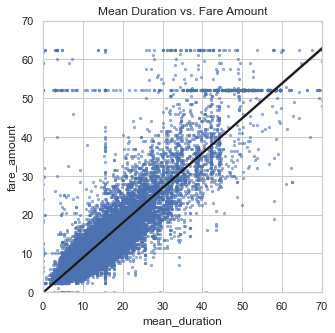

In [30]:
# Create a scatterplot for the variables of interest
sns.set(style='whitegrid')
fig = plt.figure()
fig.set_figwidth(5)
fig.set_figheight(5)
sns.regplot(x=df_trips.mean_duration, y=df_trips.fare_amount, ci=95,
            scatter_kws={'alpha': 0.5, 's': 5},
            line_kws={'color': 'k'})
plt.ylim(0, 70); plt.xlim(0, 70)
plt.title('Mean Duration vs. Fare Amount')
plt.show()

The `mean_duration` variable correlates with the target variable. There are two horizontal lines around fare amounts of 52 dollars and 63 dollars. It's known that the top line represents \$62.50 maximum bounding value that was imputed for outliers.   
But what is the other line and how many are there?

Check the value of the rides in the second horizontal line in the scatter plot.

In [31]:
df_trips.loc[df_trips.fare_amount > 50, 'fare_amount'].value_counts()

52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
51.0      7
60.0      6
55.0      6
51.5      6
53.0      4
52.5      4
61.0      3
62.0      3
55.5      3
56.0      3
56.5      3
58.5      2
59.5      2
61.5      2
57.0      2
54.0      2
58.0      1
54.7      1
54.5      1
Name: fare_amount, dtype: int64

Examine the first 30 of these trips.

In [32]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
df_trips.loc[df_trips.fare_amount == 52.0, 'RatecodeID'].value_counts()

2    513
1      1
Name: RatecodeID, dtype: int64

**Question:** What do you notice about the first 30 trips?

==> Most of the data points around fare amount of 52 dollars are attributed to JFK, which is Joh F. Kennedy International Airport and they're likely to be the flat rate of taxi taken by the tourists to the airport.  

### Task 4a. Isolate modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

In [33]:
predictors = ['mean_duration', 'mean_distance', 
              'passenger_count', 'VendorID', 'rush_hour']
target = ['fare_amount']

In [34]:
df_model = df_trips[predictors+target].copy()

### Task 4b. Pair plot

Create a pairplot to visualize pairwise relationships between the numerical variables of interest: `fare_amount`, `mean_duration`, and `mean_distance`.

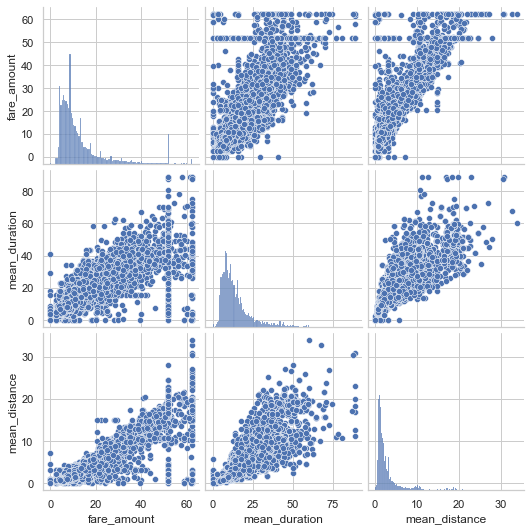

In [35]:
# Create a pairplot to visualize pairwise relationships between variables in the data
ax = sns.pairplot(df_model[['fare_amount', 'mean_duration', 'mean_distance']])


These variables all show linear correlation with each other. Investigate this further.

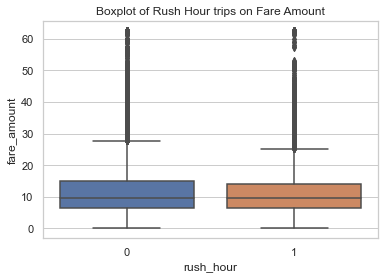

In [36]:
# Examine the relationship between Categorical & Numerical variables.
rush_ax = sns.boxplot(x=df_model['rush_hour'], y=df_model['fare_amount'])
rush_ax.set(title='Boxplot of Rush Hour trips on Fare Amount')
plt.show()

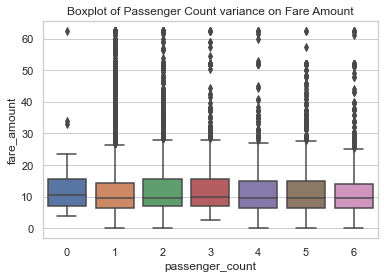

In [37]:
passenger_ax = sns.boxplot(x=df_model['passenger_count'], y=df_model['fare_amount'])
passenger_ax.set(title='Boxplot of Passenger Count variance on Fare Amount')
plt.show()

### Task 4c. Identify correlations

Next, code a correlation matrix to help determine most correlated variables.

In [38]:
# Correlation matrix to help determine most correlated variables
df_trips[predictors+target].corr()

,mean_duration,mean_distance,passenger_count,VendorID,rush_hour,fare_amount
mean_duration,1.000000,0.874864,0.015852,0.001876,-0.021583,0.859105
mean_distance,0.874864,1.000000,0.013428,0.004741,-0.039725,0.910185
passenger_count,0.015852,0.013428,1.000000,0.266463,-0.022035,0.014942
VendorID,0.001876,0.004741,0.266463,1.000000,-0.002874,0.001045
rush_hour,-0.021583,-0.039725,-0.022035,-0.002874,1.000000,-0.020075
fare_amount,0.859105,0.910185,0.014942,0.001045,-0.020075,1.000000


Visualize a correlation heatmap of the data.

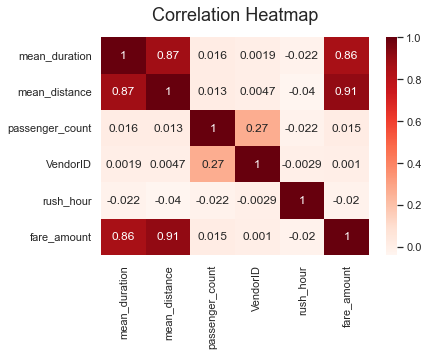

In [39]:
# Create correlation heatmap
corr_heatmap = sns.heatmap(df_trips[predictors+target].corr(), annot=True, cmap='Reds')
plt.title('Correlation Heatmap', y=1.05, fontsize=18)
plt.show()

- Both `mean_distance` & `mean_duration` are correlated with `fare_amount`, but they also correlated to each other which is undesirable as it is likely to introduce multi-collinearity. 
- While `passenger_count` & `rush_hour` do not illustrate a significant effect & strong association with the target, they may be ignored or selectively included as covariates.

However, correlated predictor variables can still be used to create an accurate predictor if the prediction itself is more important than using the model as a tool to draw statistical inference about data.

Hence, try modeling with both variables even though they are correlated.

<img src="images/Construct.png" width="100" height="100" align=left>

## PACE: **Construct**

After analysis and deriving variables with close relationships, it is time to begin constructing the model.

### Task 5a. Split data into outcome variable and features

In [40]:
# Check if all the model variables are in the right shape for modeling 
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22699 entries, 24870114 to 17208911
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_duration    22699 non-null  float64
 1   mean_distance    22699 non-null  float64
 2   passenger_count  22699 non-null  int64  
 3   VendorID         22699 non-null  int64  
 4   rush_hour        22699 non-null  int64  
 5   fare_amount      22699 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1.7 MB


In [41]:
X = df_model.drop(columns=['fare_amount', 'passenger_count'])
y = df_model['fare_amount']

# Display first few rows
print(X, y, sep='\n\n')

           mean_duration  mean_distance  VendorID  rush_hour
24870114       22.847222       3.521667         2          0
35634249       24.470370       3.108889         1          0
106203690       7.250000       0.881429         1          1
38942136       30.250000       3.700000         2          0
30841670       14.616667       4.435000         2          0
...                  ...            ...       ...        ...
14873857        8.594643       1.098214         2          1
66632549       59.560417      18.757500         2          0
74239933        6.609091       0.684242         2          0
60217333       16.650000       2.077500         2          0
17208911        9.405556       1.476970         1          0

[22699 rows x 4 columns]

24870114     13.0
35634249     16.0
106203690     6.5
38942136     20.5
30841670     16.5
             ... 
14873857      4.0
66632549     52.0
74239933      4.5
60217333     10.5
17208911     11.0
Name: fare_amount, Length: 22699, dtype: fl

### Task 5b. Pre-process data


In [42]:
# Convert VendorID to string
X = X.astype({'VendorID': str})

# Dummy encode categorical variables
X['VendorID'] = pd.get_dummies(X['VendorID'], drop_first=True)
X

,mean_duration,mean_distance,VendorID,rush_hour
24870114,22.847222,3.521667,1,0
35634249,24.470370,3.108889,0,0
106203690,7.250000,0.881429,0,1
38942136,30.250000,3.700000,1,0
30841670,14.616667,4.435000,1,0
...,...,...,...,...
14873857,8.594643,1.098214,1,1
66632549,59.560417,18.757500,1,0
74239933,6.609091,0.684242,1,0
60217333,16.650000,2.077500,1,0


### Split data into training and test sets

In [43]:
from sklearn.model_selection import train_test_split

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=X['VendorID'])


### Standardize the data

In [44]:
from sklearn.preprocessing import StandardScaler

# Standardize the X variables
sc = StandardScaler()
sc.fit(X_train[['mean_distance', 'mean_duration']])
features_train_scaled = sc.transform(X_train[['mean_distance', 'mean_duration']])
scaled_df = pd.DataFrame(features_train_scaled, index=X_train.index, columns=['mean_distance', 'mean_duration'])
X_train_scaled = pd.concat([scaled_df, X_train.iloc[:, 2:]], axis=1)
X_train_scaled.head(3)

,mean_distance,mean_duration,VendorID,rush_hour
24668747,-0.421477,-0.383920,1,1
87463036,-0.032161,0.742740,0,0
72889881,-0.404221,-0.325604,1,0


### Fit the model

In [45]:
multiple_regr = sm.OLS(y_train, X_train_scaled.assign(const=1))
model = multiple_regr.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 2.594e+04
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:08:44   Log-Likelihood:                -51258.
No. Observations:               18159   AIC:                         1.025e+05
Df Residuals:                   18154   BIC:                         1.026e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
mean_distance     7.1271      0.062    114.562      0.000       7.005       7.249
mean_duration     2.8682      0.062     46.129      0.000       2.746       2.990
VendorID         -0.0390      0.061     -0.641      0.522      -0.158       0.080
rush_hour         0.2523      0.066      3.810      0.000       0.122       0.382
const            12.8405      0.049    259.555      0.000      12.744      12.937
==============================================================================
Omnibus:                    20643.649   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3100674.863
Skew:                           5.780   Prob(JB):                         0.00
Kurtosis:                      65.963   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Task 5c. Evaluate model

### Train data

Evaluate the model performance by calculating the residual sum of squares and the explained variance score (R^2). Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error.

In [46]:
# Evaluate the model performance on the training data
train_predictions = model.predict(X_train_scaled.assign(const=1)) 
R_squared = metrics.r2_score(y_train, train_predictions)
MAE = metrics.mean_absolute_error(y_train, train_predictions)
MSE = metrics.mean_squared_error(y_train, train_predictions)

print(f'R_squared: {R_squared:.3f}, MAE: {MAE:.3f}, MSE: {MSE:.3f}')

R_squared: 0.851, MAE: 2.159, MSE: 16.570


In [67]:
# Save a copy of the feature egineered vars & predicted results for downstream use
train_data = pd.DataFrame({'mean_duration': X_train['mean_duration'], 
                           'mean_distance': X_train['mean_distance'],
                           'predicted_fare': train_predictions})

### Test data

Calculate the same metrics on the test data.

In [55]:
# Scale the X_test data
features_test_scaled = sc.transform(X_test[['mean_distance', 'mean_duration']])
X_test_scaled = pd.concat([pd.DataFrame(features_test_scaled, index=X_test.index, columns=['mean_distance', 'mean_duration']), X_test[['VendorID', 'rush_hour']]], axis=1)
X_test_scaled.head(3)

,mean_distance,mean_duration,VendorID,rush_hour
53057522,-0.543936,-0.665281,0,0
53523238,-0.536250,-0.609394,0,1
101954206,0.163138,0.213586,0,0


In [56]:
# Evaluate the model performance on the testing data
test_predictions = model.predict(X_test_scaled.assign(const=1)) 
R_squared = metrics.r2_score(y_test, test_predictions)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)

print(f'R_squared: {R_squared:.3f}, MAE: {MAE:.3f}, MSE: {MSE:.3f}')

R_squared: 0.823, MAE: 2.194, MSE: 19.602


**Note:** The model performance is high on both training & test sets, 
indicating that there is little bias in the model and that model is not overfit. 

The mean absolute error (MAE) is informative here because it allows us to assess whether the squared evaluation metric (MSE) for the model is heavily affected by the outliers in smaller test sample compared to the training set. 

<img src="images/Execute.png" width="100" height="100" align=left>

## PACE: **Execute**
Review the model coefficients & important model assumptions concerning with prediction accuracy.

### Task 6a. Examine Model Results

In explanatory modeling (ie. research context), the influence of outliers and model assumptions may be reviewed, in addition to the metrics to assess how well the model fits the data. 

In [57]:
# Get `actual`,`predicted`, and `residual` for the test set, 
# and store them as columns in a `results` dataframe.
results = pd.DataFrame({'actual': y_test, 
                        'predicted': test_predictions,
                        'residual': y_test - test_predictions})
results


,actual,predicted,residual
53057522,6.0,7.055671,-1.055671
53523238,6.0,7.523003,-1.523003
101954206,13.5,14.615839,-1.115839
903911,7.0,7.840626,-0.840626
44354023,5.0,6.122204,-1.122204
...,...,...,...
89655653,10.5,6.489679,4.010321
14139464,8.5,10.761983,-2.261983
23199299,7.5,6.846735,0.653265
8234396,7.5,6.711961,0.788039


In [66]:
# Save a copy of the feature egineered vars & predicted results for downstream use
test_data = pd.DataFrame({'mean_duration': X_test['mean_duration'],
                          'mean_distance': X_test['mean_distance'],
                          'predicted_fare': test_predictions})

In [62]:
# Merge the data and save as a complete set
data = pd.concat([test_data, train_data], axis=0)

,mean_duration,mean_distance,predicted_fare
53057522,7.737984,0.974884,7.055671
53523238,8.305229,1.002353,7.523003
101954206,16.658333,3.501667,14.615839
903911,7.916667,1.216667,7.840626
44354023,5.328862,0.721707,6.122204
...,...,...,...
77926221,6.997778,1.303333,7.462593
14060322,12.066667,1.800000,10.176756
63829426,10.807143,1.395000,8.974139
74128445,7.373333,1.002000,6.967744


In [65]:
data.to_csv('nyc_selfpreds_means.csv', index=True)
    

### Task 6b. Visualize model results

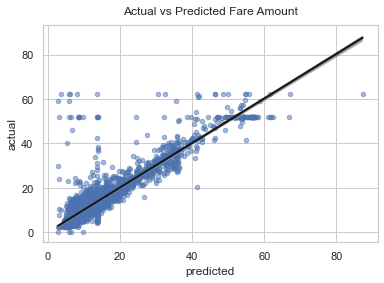

In [60]:
# Create a scatterplot to visualize `predicted` over `actual`
ax = sns.regplot(x=results.predicted, y=results.actual, ci=95,
                 scatter_kws={'alpha': 0.5, 's': 20}, line_kws={'color': 'k'})
plt.setp(ax.collections[1], alpha=0.4)
plt.title('Actual vs Predicted Fare Amount', y=1.02)
plt.show()

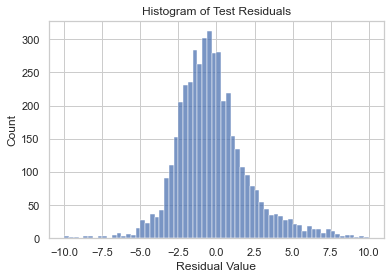

In [61]:
# Visualize the distribution of the `residuals`
norm_fig = sns.histplot(results.residual, bins='auto', binrange=[-10, 10])
plt.title('Histogram of Test Residuals')
plt.xlabel('Residual Value'); plt.ylabel('Count')
plt.show()

In [62]:
# Calculate residual mean
residual_mean = results['residual'].mean() 
residual_mean

0.11679883216969629

*The distribution of residuals is approximately normal and has a mean of 0.12, which suggests that the outcome variable is well explained by the model & unbiased.*

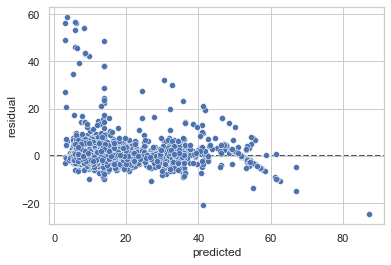

In [63]:
# Create a scatterplot of `residuals` over `predicted`
resid_plot = sns.scatterplot(x='predicted', y='residual', data=results)
resid_plot.axhline(0, ls='--', color='k', zorder=0)
plt.show()

*The model's residuals are evenly distributed around the mean of 0 {Homoscedascity & Independent observations are complied}, with  exception of the sloping points from the upper-left to the lower-right corner, which are known for as the imputed maximum value of \\$62.50 & the flat rate of \\$52 for JFK airport from the EDA.* 

### Task 9c. Coefficients

In [64]:
# Output the model's coefficients
model.params

mean_distance     7.127109
mean_duration     2.868208
VendorID         -0.038963
rush_hour         0.252251
const            12.840528
dtype: float64

**Note:** As the `mean_distance` & `mean_duration` are scaled, common misinterpretation can occur if the variables were treated similar to miles or minutes.

In [65]:
# To translate coefficients back to miles instead of S.D (unscaled):
# 1. Calculate SD of the feature in X_train data
print(X_train['mean_distance'].std(), X_train['mean_duration'].std())

# 2. Divide the model coefficient by the standard deviation
print(model.params[0] / X_train['mean_distance'].std(), 
      model.params[1] / X_train['mean_duration'].std())

3.5736726886746744 10.150115473028745
1.9943373724702098 0.28257885416392614


What do these coefficients mean? How should they be interpreted? Which feature had the greatest effect on trip fare?

*&emsp;(1)  For every mile in the mean distance of a trip, the fare amount is expected to raise by 2 dollar on average, while holding other variable constant. Or, for every 3.57 miles traveled, the fare is increased by a mean of 7.13 dollars.<br>
&emsp;(2) A delay on the trip caused by traffic & waiting time is expected to raise the fare amount by 2.87 dollar on average with every minute that goes by, given the same mean distance, vendor & hour of the day.<br>
&emsp;(3) On average, a trip offered by VeriFone Inc. is expected to command a fare amount of roughly 4 pennies lower than a trip in Creative Mobile Technologies.<br>
&emsp;(4) For a trip during rush hour, it is expected to command a fare amount of a quarter high than normal hour on average, while holding other variables constant.*  

# NOTES

There are some things to note that differ from best practice or from how tasks are typically performed.

- Imputing the fare amount for `RatecodeID 2` after training the model and then calculating model performance metrics on the post-imputed data is not best practice. It would be better to separate the rides that did *not* have rate codes of 2, train the model on that data specifically, and then add the `RatecodeID 2` data (and its imputed rates) *after*. This would prevent training the model on data that you don't need a model for, and would likely result in a better final model. However, the steps were combined for simplicity.
</br></br>